# League of Legends Role Models: A Recommendation System for Skill Training and Study

__Gwen Rathgeber | [GitHub](https://github.com/gwenrathgeber) | [LinkedIn](https://www.linkedin.com/in/gwenrathgeber/)__


Special thanks to [Uthgar](https://twitter.com/Dr_Uthgar) at Mobalytics.gg for suggesting this project!


The accompanying Flask app to this project can be viewed at https://github.com/gwenrathgeber/lol_role_models_app.
  
    
      
_N.B: this notebook is meant to summarize the code and logic behind developing the [Flask app](https://github.com/gwenrathgeber/lol_role_models_app) which is the true final product of the project, and is not meant to be run top-to-bottom locally (though it can be)._

_If you do wish to run this code locally, please be aware that querying the Riot API for our Role Models gameplay data takes over 24 hours on a basic developer key even with our implementation of multi-threading API requests by region, and you may wish to make alterations to the `scrape_seeds` function to limit the number of matches you are querying. The scraper function will save as it goes, so running the scraper intermittently and refreshing your API key every 24 hours is also viable._

## Problem Statement

League of Legends is a Multiplayer Online Battle Arena game known for attracting devoted players with a strong competitive drive. As one of the earliest games to popularize online video game streaming on platforms such as Twitch.tv, League demonstrated the appeal of not only playing games, but watching others compete. Due to the complexity of the game, a highly effective method of improving is studying the gameplay of higher-skilled players. We wish to improve this process for players by providing a recommendation system which matches players with Role Models: high-ranking players whose playstyles are similar to the user. Users can then use other tools to watch replays of recent games played by their recommended Role Models, simplifying and enhancing the process of finding high-level games to study through personalization and filtering.

## Executive Summary
In order to implement the recommender, we require a body of high-level players who will be recommended to users. All necessary data will be acquired from the Riot Games API, which can provide match-level data for games played by on a given account.

After scraping the data we need, we will need to combine each players' match history into a single row of aggregate statistics, using subject-matter knowledge to identify metrics which will be represent distinctive play patterns while also being comparable between lower- and higher-skilled players.

Finally, we will implement the recommendation system itself, which will involve pulling an individual player's match history, performing our aggregation, and comparing their statistics against our Role Model candidates.

Evaluation of this recommendation system is unfortunately limited to subjective interpretation of results by myself and test users, as it is not designed to drive a particular business objective or KPI. However, if a similar tool was deployed on one of the many stat-tracking and personal improvement websites which exist for League of Legends Players, some important target metrics would include the page bounce rate for the tool, churn and retention rates of tool users vs. non-users, and user feedback in the form of qualitative and quantitative satisfaction surveys that could be added to the results page. 

### Table of Contents
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Data Dictionary](#Data-Dictionary)
- [API Scraping](#API-Scraping)
- [Data Processing](#Data-Processing)
- [Recommender](#Recommender)
- [Future Work](#Future-Work)
- [References](#References)

## Data Dictionary

The following endpoints of the Riot API were used over the course of this project, please consult their documentation for details of the fields:
 - [Summoner by Account ID Endpoint](https://developer.riotgames.com/apis#summoner-v4/GET_getByAccountId)
 - [Summoner by Account Name Endpoint](https://developer.riotgames.com/apis#summoner-v4/GET_getBySummonerName)
 - [Challenger Leagues Endpoint](https://developer.riotgames.com/apis#league-v4/GET_getChallengerLeague)
 - [Match Histories Endpoint](https://developer.riotgames.com/apis#match-v4/GET_getMatchlist)
 - [Match Data Endpoint](https://developer.riotgames.com/apis#match-v4/GET_getMatch)
 - [Timeline Data Endpoint](https://developer.riotgames.com/apis#match-v4/GET_getMatchTimeline)

The following is a representation of the custom fields we generated in our game data analysis:


Column | Data Type| Description
-|-|-
csd_10 | float|Average CS (Creep Score) Difference Between Player and Opponent at 10 minutes
gold_d_10 | float| Average Gold Difference Between Player and Opponent at 10 minutes
xpd_10| float|Average Experience Difference Between Player and Opponent at 10 minutes
dmg_share| float| Average Percent of Team's Total Damage to Champions Dealt by Player
dmg_taken_share| float| Average Percent of Team's Total Damage Taken Received by Player
vision_score| float| Average Vision Score of Player
kill_participation|float|Average Percent of Team's Kills a Player was Involved In
obj_dmg_share|float| Average Percent of Team's Total Damage to Epic Monsters and Structures by Player
dragons|float|Average Percent of Dragons Taken by Player's Team
barons|float|Average Percent of Barons Taken by Player's Team
wards_cleared |float | Average Ratio of Wards Cleared to Wards Placed by Player
vision_wards_purchased |float | Average Ratio of Vision Wards Purchased to Wards Placed by Player
kda_early | float| Average Ratio of Kills + Deaths + Assists Occurring before 10 minutes
kda_mid |float | Average Ratio of Kills + Deaths + Assists Occurring between 10 and 20 minutes
kda_late |float| Average Ratio of Kills + Deaths + Assists Occurring after 20 minutes
solo_kills |float | Average Ratio of Kills with no Assists by Teammates
teamfight_kills |float | Average Ratio of Kills with two or more Assists by Teammates
skirmish_kills |float | Average Ratio of Kills with only one Assist by Teammates
wards_early |float | Average Ratio of Wards Placed before 10 minutes
wards_mid |float |  Average Ratio of Wards Placed between 10 and 20 minutes
wards_late |float |  Average Ratio of Wards Placed after 20 minutes
most_played_champ |string | Most Frequently Played Champion
most_played_role |string | Most Frequently Played Role
most_played_lane | string| Most Frequently Played Lane
role |string | Simplified Most Played Role
op_gg | string| URL of player's op.gg account profile
similarity|float|Euclidean Distance from Role Model Player to User


In [2]:
# Imports and constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines
import json
import time
from sklearn.preprocessing import StandardScaler
import requests
import concurrent.futures

region_base_url_dict = {'na':'na1.api.riotgames.com',
          'br':'br1.api.riotgames.com',
          'eun':'eun1.api.riotgames.com',
          'euw':'euw1.api.riotgames.com',
          'jp':'jp1.api.riotgames.com',
          'kr':'kr.api.riotgames.com',
          'la1':'la1.api.riotgames.com',
          'la2':'la2.api.riotgames.com',
          'oce':'oc1.api.riotgames.com',
          'tr':'tr1.api.riotgames.com',
          'ru':'ru.api.riotgames.com'}
            
api_key = pd.read_json('../secrets.json')['riot_api_key'][0]

timeline_by_match_id_url = '/lol/match/v4/timelines/by-match/'

match_by_match_id_url = '/lol/match/v4/matches/'

account_by_name_url = '/lol/summoner/v4/summoners/by-name/'

match_hist_by_id_url = '/lol/match/v4/matchlists/by-account/'

challenger_ladder_url = '/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5'

summoner_by_summoner_id = '/lol/summoner/v4/summoners/'

champions = requests.get('http://ddragon.leagueoflegends.com/cdn/10.16.1/data/en_US/champion.json').json()

champions_df = pd.DataFrame(champions['data']).transpose()

## API Scraping

Scraping the Riot API had some unique challenges. The rate limit for a developer key (the basic level of access) is low, at 100 requests per 2 minutes. To get a large enough pool of players to recommend as Role Models, we split up our requests by the region of each player, as each regional endpoint has its own rate limit. First, we pulled a list of all players in the Challenger division (top ~200 players per server), then used multithreading to request all their matches, with each thread querying a different region.

In [ ]:
def get_all_challengers():
    challengers_df = pd.DataFrame()
    for key, base_url in region_base_url_dict.items():
        ladder_response = requests.get(f'https://{base_url}{challenger_ladder_url}?api_key={api_key}')
        try:
            assert(ladder_response.status_code == 200)
            response_df = pd.DataFrame(ladder_response.json()['entries'])
            response_df['region'] = [key] * len(response_df)
            challengers_df = pd.concat([challengers_df,response_df])
        except:
            print(f'Bad request for {key}: {ladder_response.status_code}')
        time.sleep(1.2001)
        
    return challengers_df

In [8]:
def get_summoner_by_name(base_url, summoner_name):
    return requests.get(f'https://{base_url}{account_by_name_url}{summoner_name}?api_key={api_key}')

In [4]:
def get_summoner(base_url, summoner_id):
    return requests.get(f'https://{base_url}{summoner_by_summoner_id}{summoner_id}?api_key={api_key}')

In [5]:
def get_match_hist(account_id, base_url, queue = '420'):
    return requests.get(f'https://{base_url}{match_hist_by_id_url}{account_id}?api_key={api_key}&queue={queue}')

In [6]:
def get_match(match_id, base_url):
    return requests.get(f'https://{base_url}{match_by_match_id_url}{match_id}?api_key={api_key}'),requests.get(f'https://{base_url}{timeline_by_match_id_url}{match_id}?api_key={api_key}')

In [ ]:
def get_challenger_match_hists(region, challengers_df = all_challengers, has_account_id=False):
    challengers_df = challengers_df[['summonerId','region']]
    challengers_df['player_ids'] = [np.nan] * len(challengers_df)
    challengers_df = challengers_df[challengers_df['region'] == region]
    challengers_df.reset_index(drop=True,inplace=True)
    
    if has_account_id==False:
        for i, tuples in enumerate(challengers_df.values):
            if i % 500 == 0:
                print(f'{i} of {len(challengers_df)} account ids')
            summoner_id, region, unused_pid = tuples
            summoner = get_summoner(region_base_url_dict[region],summoner_id).json()
            account_id = summoner['accountId']
            challengers_df.loc[i,'account_ids'] = account_id
            all_challengers.loc[i,'account_ids'] = account_id
            time.sleep(1.2)
        
    challenger_match_hists = pd.DataFrame()
    for i, account_id in enumerate(challengers_df['account_ids']):
        if i % 500 == 0:
            print(f'{i} of {len(challengers_df)} match histories')
        try:
            match_hist = pd.DataFrame(get_match_hist(account_id, region_base_url_dict[challengers_df.loc[i,'region']]).json()['matches'])
            match_hist['region'] = [challengers_df.loc[i,'region']] * len(match_hist)
            match_hist['account_id'] = [account_id] * len(match_hist)
            challenger_match_hists = pd.concat([challenger_match_hists, match_hist])
        except:
            pass
        time.sleep(1.2)
    
    return challenger_match_hists

In [ ]:
def scrape_seeds(region):
    print(f'{region} thread initialized')
    start_time = time.time()
    base_url = region_base_url_dict[region]
    
    matches_list = []
    scraped_ids = set()
    timelines_list = []
    scraped_participants = set()
    unscraped_ids = set()
    scraped_matches = []
    
    with jsonlines.open(f'../data/scraped_ids_{region}.jsonl') as infile:
        print(f'reading scraped_ids_{region}')
        for line in infile.iter():
            scraped_ids.add(line)       
    
    with jsonlines.open(f'../data/unscraped_ids_{region}.jsonl') as infile:
            print(f'reading unscraped_ids_{region}')
            for line in infile.iter():
                unscraped_ids.add(line)
                
    with jsonlines.open(f'../data/matches_{region}.jsonl') as infile:
            print(f'reading matches_{region}')
            for line in infile.iter():
                scraped_matches.append(dict(line)['gameId'])     
    
    seed = pd.read_csv('../data/challenger_match_hists_ranked_only.csv')
    
    seed = seed[seed['region']==region]
    
    seed.reset_index(drop=True,inplace=True)
    
    for i, account_id in enumerate(seed['account_id']):
        if account_id not in scraped_ids or seed.loc[i,'gameId'] not in scraped_matches:
            scraped_ids.add(account_id)
            match, timeline = get_match(seed.loc[i,'gameId'], base_url)
        
            if match.status_code == 200 and timeline.status_code == 200:
                matches_list.append(match.json())
                timelines_list.append(timeline.json())
                [scraped_participants.add(part['player']['accountId']) for part in match.json()['participantIdentities']]
                scraped_matches.append(seed.loc[i,'gameId'])
            else:
                print(f'matches error: {match.status_code}\ntimelines error: {timeline.status_code}\nSummoner: {account_id}\nRegion:{region}')
            time.sleep(2.4)
        
        else:
            pass
        
        if 'match' in locals():
            if i % 100 == 0 or match.status_code == 403:
                print(f'{i} matches scraped of {len(seed)}\nRegion: {region}\n')
                try:
                    with open(f'../data/matches_{region}.jsonl', 'a') as outfile:
                        for entry in matches_list:
                            json.dump(entry, outfile)
                            outfile.write('\n')
                            matches_list = []

                    with open(f'../data/timelines_{region}.jsonl', 'a') as outfile:
                        for entry in timelines_list:
                            json.dump(entry, outfile)
                            outfile.write('\n')
                            timelines_list = []

                    with open(f'../data/scraped_ids_{region}.jsonl', 'w') as outfile:
                        for entry in scraped_ids:
                            json.dump(entry, outfile)
                            outfile.write('\n')

                    unscraped_ids = unscraped_ids.union(scraped_participants)
                    unscraped_ids -= scraped_ids

                    with open(f'../data/unscraped_ids_{region}.jsonl', 'w') as outfile:
                        for entry in unscraped_ids:
                            json.dump(entry, outfile)
                            outfile.write('\n')
                except:
                    pass

                if match.status_code == 403:
                    return None
            
    with open(f'../data/matches_{region}.jsonl', 'a') as outfile:
        for entry in matches_list:
            json.dump(entry, outfile)
            outfile.write('\n')

    with open(f'../data/timelines_{region}.jsonl', 'a') as outfile:
        for entry in timelines_list:
            json.dump(entry, outfile)
            outfile.write('\n')

    with open(f'../data/scraped_ids_{region}.jsonl', 'a') as outfile:
        for entry in scraped_ids:
            json.dump(entry, outfile)
            outfile.write('\n')

    print(f'Seeds scraped, region = {region}')

    unscraped_ids = unscraped_ids.union(scraped_participants)
    unscraped_ids -= scraped_ids
    
    with open(f'../data/unscraped_ids_{region}.jsonl', 'w') as outfile:
        for entry in unscraped_ids:
            json.dump(entry, outfile)
            outfile.write('\n')
    

In [8]:
def remove_duplicates(region):
    match_list = []
    timeline_list = []
    
    with jsonlines.open(f'../data/matches_{region}.jsonl') as infile:
                for line in infile.iter():
                    match_list.append(line) 
                    
    with jsonlines.open(f'../data/timelines_{region}.jsonl') as infile:
            for line in infile.iter():
                    timeline_list.append(line)
    
    del infile
    ranked_matches = []
    ranked_timelines = []
    is_ranked = []
    game_ids = set()
    
    for i, match in enumerate(match_list):
        if match['queueId'] == 420 and match['gameId'] not in game_ids:
            ranked_matches.append(match)
            is_ranked.append(i)
            game_ids.add(match['gameId'])
    del match_list
    
    
    with open(f'../data/cleaned/matches_{region}.jsonl', 'w') as outfile:
        for entry in ranked_matches:
            json.dump(entry, outfile)
            outfile.write('\n')
    del ranked_matches
    
    
    for i, timeline in enumerate(timeline_list):
        if i in is_ranked:
            ranked_timelines.append(timeline)
    del timeline_list
            
    

    with open(f'../data/cleaned/timelines_{region}.jsonl', 'w') as outfile:
        for entry in ranked_timelines:
            json.dump(entry, outfile)
            outfile.write('\n')   
    del ranked_timelines
    del is_ranked
    del game_ids

In [9]:
def remove_short_games(region):
    match_list = []
    timeline_list = []
    
    with jsonlines.open(f'../data/cleaned/matches_{region}.jsonl') as infile:
                for line in infile.iter():
                    match_list.append(line) 
    del infile
                 
    with jsonlines.open(f'../data/cleaned/timelines_{region}.jsonl') as infile:
                for line in infile.iter():
                    timeline_list.append(line) 
    del infile
                    
    good_matches = []
    good_timelines = []
    valid = []
    game_ids = set()
    
    for i, match in enumerate(match_list):
        if match['gameDuration'] / 60 > 15 and match['gameId'] not in game_ids:
            add = True
            # Remove games where a player didn't reach level 6 (based on EDA)
            for participant in match['participants']:
                if participant['stats']['champLevel'] < 7:
                    add = False
            if add:
                good_matches.append(match)
                valid.append(i)
                game_ids.add(match['gameId'])
            else:
                pass
    
    del match_list
  
    with open(f'../data/cleaned/matches_{region}.jsonl', 'w') as outfile:
        for entry in good_matches:
            json.dump(entry, outfile)
            outfile.write('\n')
    del good_matches
    
    for i, timeline in enumerate(timeline_list):
        if i in valid:
            good_timelines.append(timeline)
    
    del timeline_list
            
    

    with open(f'../data/cleaned/timelines_{region}.jsonl', 'w') as outfile:
        for entry in good_timelines:
            json.dump(entry, outfile)
            outfile.write('\n')
            
    del good_timelines
    del valid
    del game_ids

Pulling all Challenger players' match histories:

In [ ]:
all_challengers = get_all_challengers()

all_challengers.reset_index(drop=True,inplace=True)

In [ ]:
match_hist_list = []
with concurrent.futures.ThreadPoolExecutor(max_workers = 11) as executor:
    for result in executor.map(get_challenger_match_hists, region_base_url_dict.keys()):
        match_hist_list.append(result)

In [ ]:
challenger_match_hists = pd.concat(match_hist_list)

In [ ]:
challenger_match_hists.reset_index(drop=True,inplace=True)

In [ ]:
challenger_match_hists.to_csv('../data/challenger_match_hists_ranked_only.csv', index=False)

Downloading match and timeline data for all challenger match histories:

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers = 11) as executor:
    executor.map(scrape_seeds, region_base_url_dict.keys())

And finally removing all duplicate games and games which lasted less than 15 minutes:

In [ ]:
for region in region_base_url_dict.keys():
    remove_duplicates(region)

In [ ]:
for region in region_base_url_dict.keys():
    remove_short_games(region)

## Data Processing

When aggregating stats, we focused on using ratios and percents rather than hard numbers. This is because our goal is to compare low-level to high-level players. If we simply went by, say, gold earned by the 10 minute mark, high-level players would almost always have higher scores on this metric than low-level players. This is an "apples to oranges" situation we want to avoid. **Your playstyle should reflect the way you approach the game, not your rank.**

There are still limitations here, as there are certain characteristics of high-level games that are very difficult to control for. For example, it's well-known that high-level games have a shorter average duration; this will in turn affect metrics we are interested in which relate to aggressiveness or vision focus throughout different stages of the game. We wouldn't want to drop those metrics however, as they give valuable insights into a player's approach to the game. People who push their opportunities to their limits in the early game are very different from players that have a "farm until late" approach and only pick fights once the whole team is grouped up. 

The last major consideration was divide by zero errors. In order to avoid these, we add 1 to the divisor of most fields. This preserves the distribution of the data but sacrifices some intelligibility if the raw numbers are displayed to users.

Here are *some* examples of stats we pulled (for a full list, please see the [Data Dictionary](#Data-Dictionary):

**Fighting and Aggression**  
-% of kills that are assisted by 0, 1, or more teammates  
-Average % of team’s total damage delivered and taken  
-Average % Kill Participation  
-Share of kills which occur in each stage of the game  

**Vision and Objective Control**  
-Share of wards placed in each stage of the game  
-Dragon and Baron Control  
-Average % of team’s total objective damage  

**Laning Stats**  
-Average Gold and EXP lead/deficit on lane opponent  
-Share of kills occurring in the first 10 minutes of the game  
-% of wards placed in the first 10 minutes of the game  



In [23]:
def get_stats(summoner, region, matches, timelines, team_participants = ([1,2,3,4,5],[6,7,8,9,10])):
# For each player:
    output = pd.DataFrame(columns=['champ_played', 'role','lane', 'csd_10',
                                  'gold_d_10','xpd_10','dmg_share','dmg_taken_share','vision_score',
                                  'kill_participation','obj_dmg_share','dragons','barons','wards_cleared',
                                  'vision_wards_purchased','kda_early', 'kda_mid', 'kda_late', 
                                   'solo_kills', 'teamfight_kills', 'skirmish_kills', 'wards_early', 
                                   'wards_mid', 'wards_late'])
    # Main role = most played role where role is played > 40% of the time
    # Main champion = most played champion
    # Select all matches and timelines that they are in
    for i, match in enumerate(matches):
        is_in_game = summoner in [summoner['player']['summonerId'] for summoner in match['participantIdentities']]
        if is_in_game:
        # For each match:
        # Match info:
            game_id = match['gameId']
            player_id = int([player['participantId'] for player in match['participantIdentities'] if player['player']['summonerId'] == summoner][0]) - 1
            player_name = match['participantIdentities'][player_id]['player']['summonerName']
            
            # Identify champion played
            champ_played = match['participants'][player_id]['championId']
            
            # Identify role played
            role = match['participants'][player_id]['timeline']['role']
            lane = match['participants'][player_id]['timeline']['lane']
            # Identify lane opponent
            team = match['participants'][player_id]['teamId']
            team_index = int(str(team)[0]) - 1
            teammates = team_participants[team_index]
               
            # Get CSD, GoldD and XPD @ 10
            csd_10 = match['participants'][player_id]['timeline']['creepsPerMinDeltas']['0-10']
            gold_d_10 = match['participants'][player_id]['timeline']['goldPerMinDeltas']['0-10']
            xpd_10 = match['participants'][player_id]['timeline']['xpPerMinDeltas']['0-10']
            
            # Get DMG share
            total_dmg = np.sum([player['stats']['totalDamageDealtToChampions'] for player in match['participants'] if player['teamId'] == team])
            dmg_share = match['participants'][player_id]['stats']['totalDamageDealtToChampions'] / total_dmg
            
            # Get DMG Taken share
            total_dmg_taken = np.sum([player['stats']['totalDamageTaken'] for player in match['participants'] if player['teamId'] == team])
            dmg_taken_share = match['participants'][player_id]['stats']['totalDamageTaken'] / total_dmg_taken
            
            # Get vision score
            vision_score = match['participants'][player_id]['stats']['visionScore']
            
            # Get overall kill participation
            team_kills = np.sum([player['stats']['kills'] for player in match['participants'] if player['participantId'] in teammates]) + 1
            kill_participation = (match['participants'][player_id]['stats']['kills'] + match['participants'][player_id]['stats']['assists']) / team_kills
            
            # % of team's objective damage % of team's turret damage
            total_obj_dmg = np.sum([player['stats']['damageDealtToObjectives'] for player in match['participants'] if player['teamId'] == team])
            obj_dmg_share = match['participants'][player_id]['stats']['damageDealtToObjectives'] / total_obj_dmg
            
            # Team % of dragons killed
            team_dragons = match['teams'][team_index]['dragonKills']
            total_dragons = team_dragons + match['teams'][0 if team_index == 1 else 1]['dragonKills']
            dragons = team_dragons / (total_dragons + 1)
            
            # Team % of barons killed
            team_barons = match['teams'][team_index]['baronKills']
            total_barons = team_barons + match['teams'][0 if team_index == 1 else 1]['baronKills']
            barons = team_barons / (total_barons + 1)
            
            # Get wards cleared
            wards_cleared = match['participants'][player_id]['stats']['wardsKilled']
            
            # Get pinks purchased
            vision_wards_purchased = match['participants'][player_id]['stats']['visionWardsBoughtInGame']
            
            # For each timeline:
            timeline = timelines[i]
            
            kills = 0
            kda = 0
            kda_early = 0
            kda_mid = 0
            kda_late = 0
            solo_kills = 0
            teamfight_kills = 0
            skirmish_kills = 0
            wards = 0
            wards_early = 0
            wards_mid = 0
            wards_late = 0
            
            for i, frame in enumerate(timeline['frames']):
                for event in frame['events']:
                    # Get 0-10 K+D+A
                    # Get 10-20 K+D+A
                    # Get 20+ K+D+A
                    if event['type'] == 'CHAMPION_KILL':
                        if (player_id + 1) == event['killerId'] or (player_id + 1) == event['victimId'] or (player_id + 1) in event['assistingParticipantIds']:
                            kda += 1
                            if i < 12:
                                kda_early += 1
                            elif i < 22:
                                kda_mid += 1
                            else:
                                kda_late += 1

                        if (player_id + 1) == event['killerId']:
                            kills += 1
                    # get number of solo kills
                    # get number of skirmish kills
                    # get number of teamfight kills
                            if event['assistingParticipantIds'] == []:
                                solo_kills += 1
                            if len(event['assistingParticipantIds']) == 1:
                                skirmish_kills += 1
                            if  len(event['assistingParticipantIds']) > 1:
                                teamfight_kills += 1
                    # Get 0-10 wards placed
                    # Get 10-20 wards placed
                    # Get 20+ wards placed
                    if event['type'] == 'WARD_PLACED' and (player_id + 1) == event['creatorId']:
                        wards += 1
                        if i < 12:
                            wards_early += 1
                        elif i < 22:
                            wards_mid += 1
                        else:
                            wards_late += 1 
            
            solo_kills /= kills + 1
            skirmish_kills /= kills + 1
            teamfight_kills /= kills + 1
            wards_early /= wards + 1
            wards_mid /= wards + 1
            wards_late /= wards + 1 
            kda_early /= kda + 1
            kda_mid /= kda + 1
            kda_late /= kda + 1
            
            # Wards cleared and vision wards purchased as a % of wards placed
            wards_cleared /= wards + 1
            vision_wards_purchased /= wards + 1
            
            output = output.append({'champ_played':champ_played, 'role':role, 'lane':lane,
             'csd_10':csd_10,'gold_d_10':gold_d_10,'xpd_10':xpd_10,'dmg_share':dmg_share,
             'dmg_taken_share':dmg_taken_share,'vision_score':vision_score,
             'kill_participation':kill_participation,'obj_dmg_share':obj_dmg_share,'dragons':dragons,
             'barons':barons,'wards_cleared':wards_cleared,'vision_wards_purchased':vision_wards_purchased,
             'kda_early':kda_early, 'kda_mid':kda_mid, 'kda_late':kda_late, 'solo_kills':solo_kills, 
             'teamfight_kills':teamfight_kills, 'skirmish_kills':skirmish_kills, 'wards_early':wards_early, 
             'wards_mid':wards_mid, 'wards_late':wards_late}, ignore_index=True)
    
    most_played_champ = output['champ_played'].value_counts().index[0]
    most_played_role = output['role'].value_counts().index[0]
    most_played_lane = output['lane'].value_counts().index[0]
    
    output.drop(columns=['champ_played','role','lane'], inplace=True)

    output = pd.DataFrame(output.mean()).transpose()
    output['summoner_id'] = [summoner]
    output['most_played_champ'] = most_played_champ
    output['most_played_role'] = most_played_role
    output['most_played_lane'] = most_played_lane
    output['region'] = region
    output['player_name'] = player_name
    return output

In [ ]:
player_df = None
for region in region_base_url_dict.keys():
    region_start_time = time.time()
    print(f'Evaluating players in {region}...\n')
    matches = []
    timelines = []
    players_to_evaluate = []
    
    with jsonlines.open(f'../data/cleaned/matches_{region}.jsonl') as infile:
        for line in infile:
            matches.append(line)
    del infile        
    with jsonlines.open(f'../data/cleaned/timelines_{region}.jsonl') as infile:
        for line in infile:
            timelines.append(line)
    del infile
    
    all_players = []

    for match in matches:
        for player in match['participantIdentities']:
            all_players.append(player['player']['summonerId'])

    players_to_evaluate = pd.Series(all_players).value_counts().reset_index(name="count").query("count > 30")["index"]
    del all_players
    region_players = pd.concat([get_stats(player, region, matches, timelines) for player in players_to_evaluate])
    player_df = pd.concat([player_df, region_players])
    print(f'{region} completed. {(time.time() - region_start_time)/60} minutes elapsed.\n')

player_df.to_csv('../data/role_models_3.csv', index=False)

To get a sense of what our data looks like, let's investigate some of the features we created:

In [7]:
features = ['csd_10', 'gold_d_10', 'xpd_10', 'dmg_share', 'dmg_taken_share',
       'vision_score', 'kill_participation', 'obj_dmg_share', 'dragons',
       'barons', 'wards_cleared', 'vision_wards_purchased', 'kda_early',
       'kda_mid', 'kda_late', 'solo_kills', 'teamfight_kills',
       'skirmish_kills', 'wards_early', 'wards_mid', 'wards_late','role']

<Figure size 864x864 with 0 Axes>

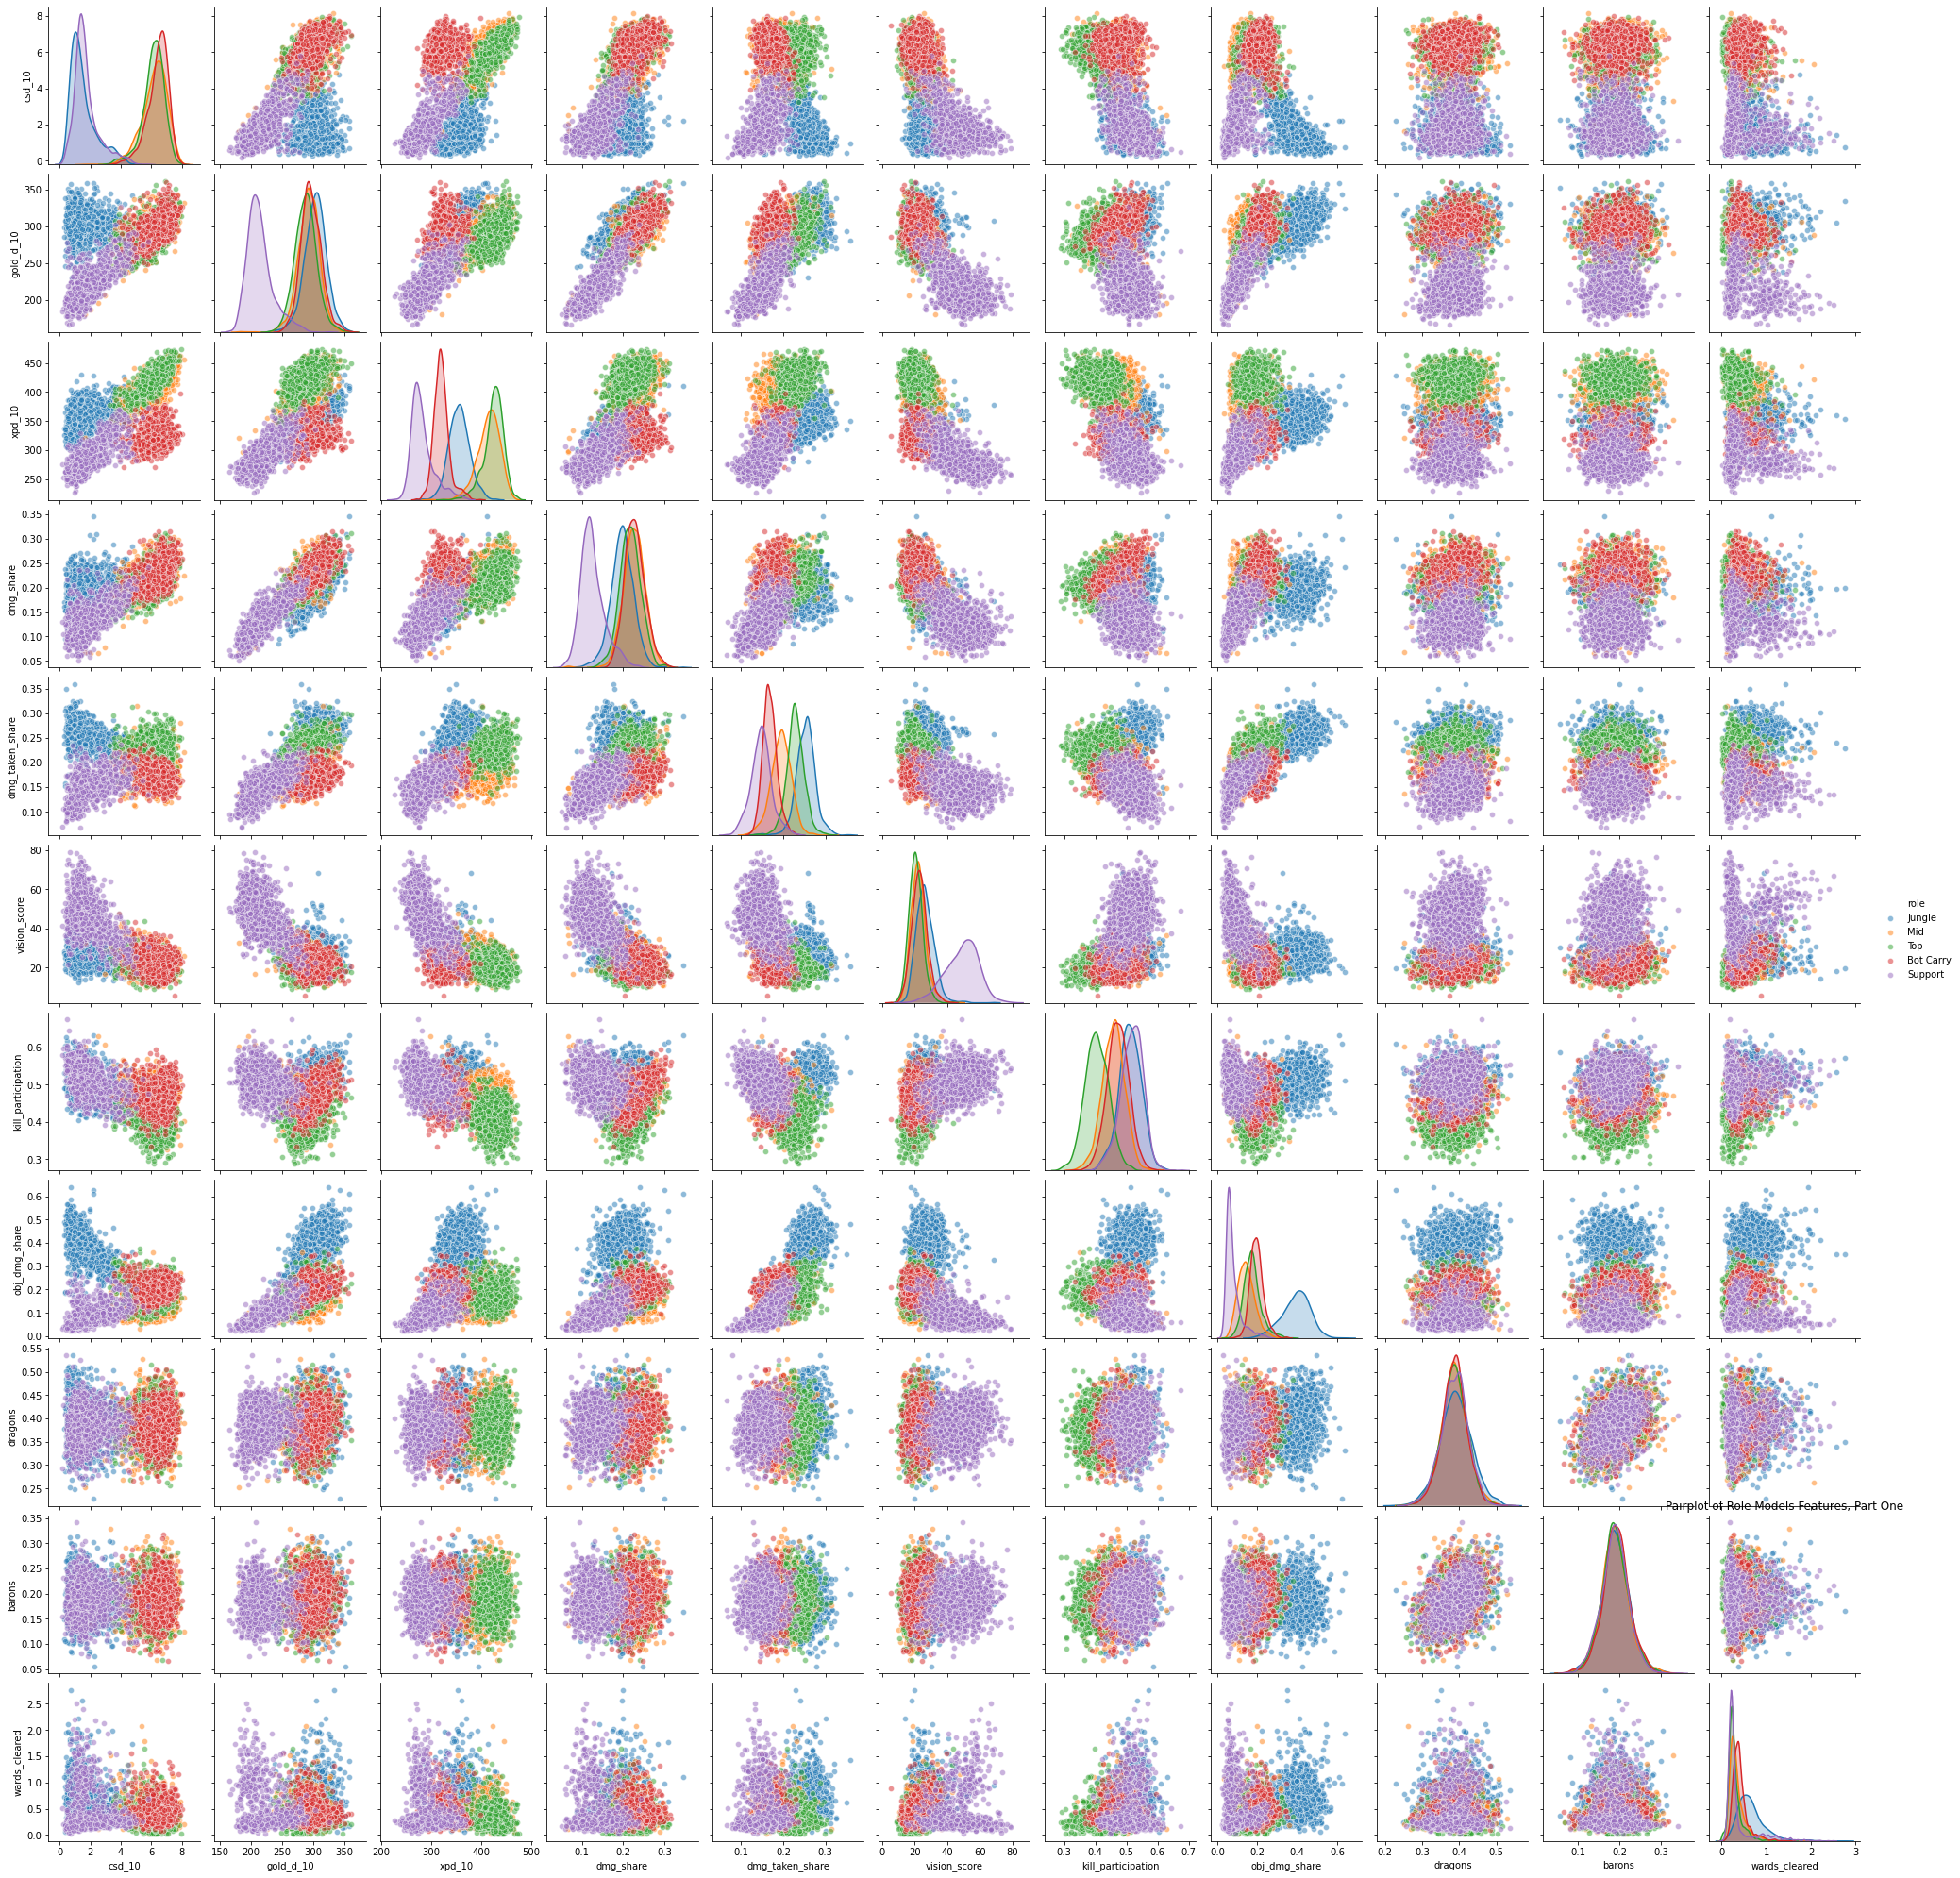

In [23]:
plt.figure(figsize=(12,12))
sns.pairplot(pd.concat([player_df[features[0:11]],player_df['role']], axis=1), hue='role', plot_kws=dict(alpha=0.5))
plt.title('Pairplot of Role Models Features, Part One');

<Figure size 864x864 with 0 Axes>

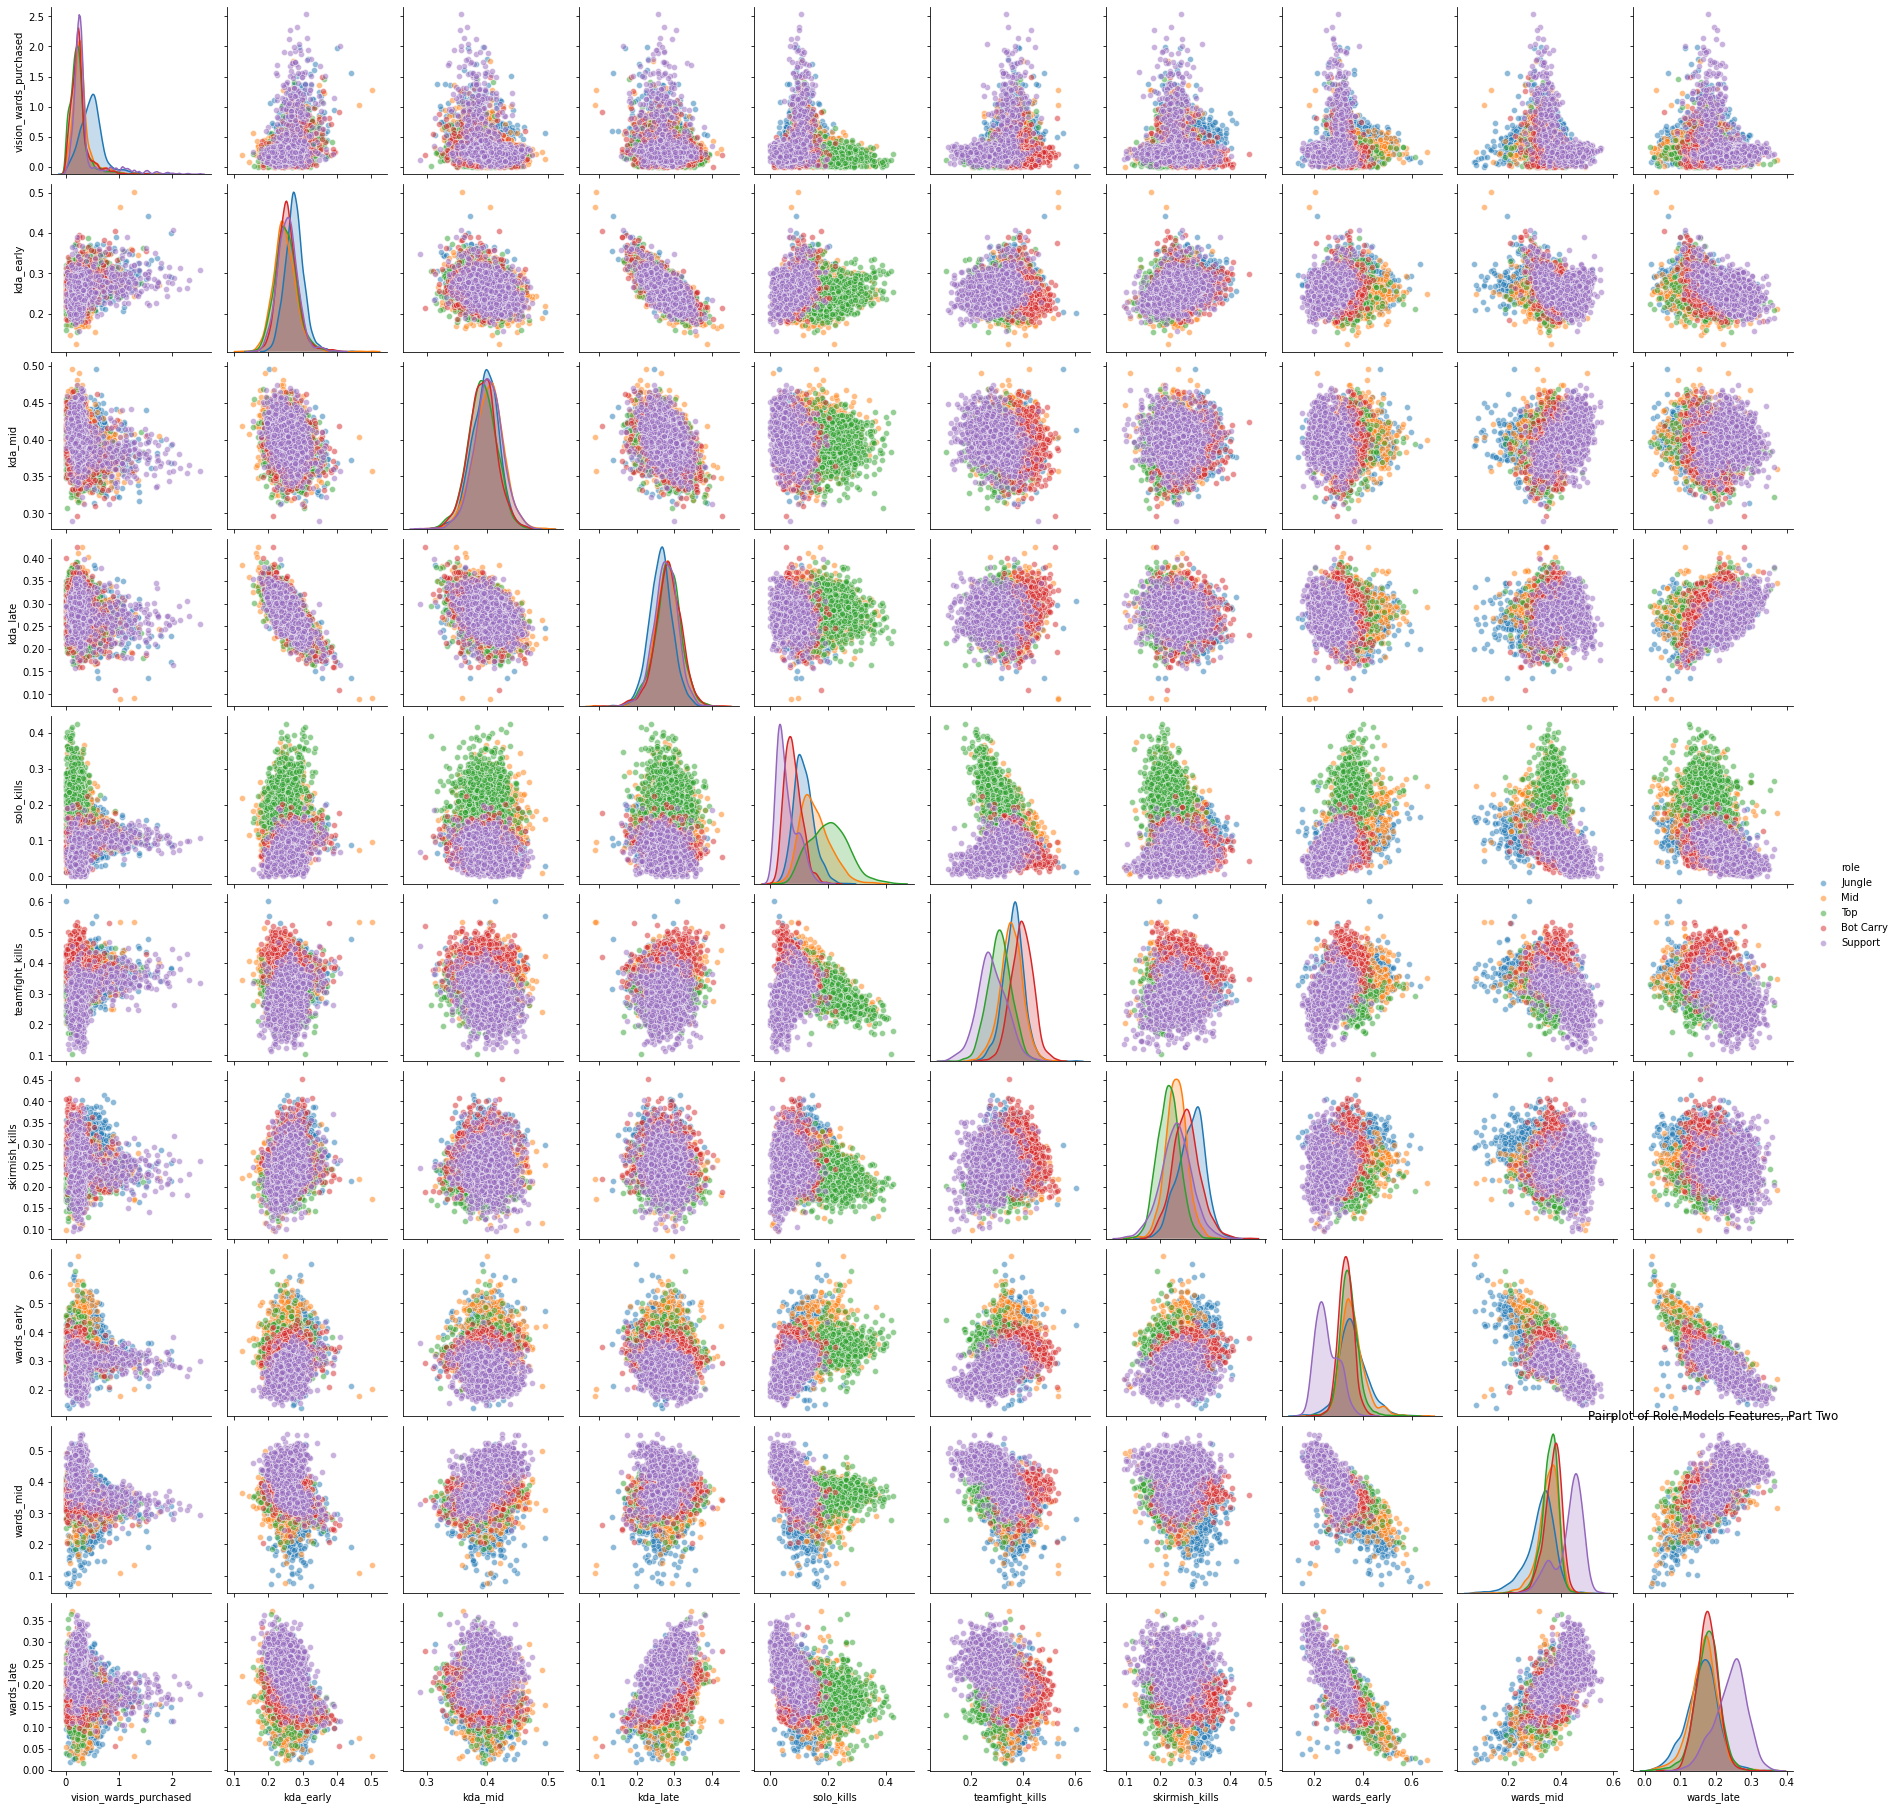

In [24]:
plt.figure(figsize=(12,12))
sns.pairplot(player_df[features[11:]], hue='role', plot_kws=dict(alpha=0.5))
plt.title('Pairplot of Role Models Features, Part Two');

Right off the bat, we can see that there aren't clear correlations or groups in our data, apart from Supports vs. non-Supports. While Support mains do tend to show some differentiation from other roles due to their lower damage share and higher warding, some players play multiple roles or potentially multiple styles within the same role. And, since many different types of champions can be viable in a given role, each with their own unique power curves over the course of the game, there is a very substantial amount of fuzzing. 

While this would be an issue for predictive modeling or clustering, it actually suits our purpose just fine. Say our user plays ~75% of their games on Assassin champions with high aggressiveness and flashy plays, but the other 25% are on Mages who are much more passive and focus on teamfights and more subtle contribution to the fight. Our recommender is then likely to select a Role Model with a *similar spread of playstyles* because they will have similar overall stats. If anything, this helps the user get more value out of the system!

To give a slightly more granular picture, here's the full scatterplot of Percentage of Kills Occurring before 10 Minutes against Average Percentage of Team's Total Damage, with Most-Played Role as the color. Like we saw above, it is basically two "blobs" of points: Supports and non-Supports. Again, the lack of clear divisions or trends in this data isn't a concern; these stats are basically a continuous spectrum, but we are trying to find the closest match in 21-dimensional space; you don't have to be in clear buckets to get a close match.

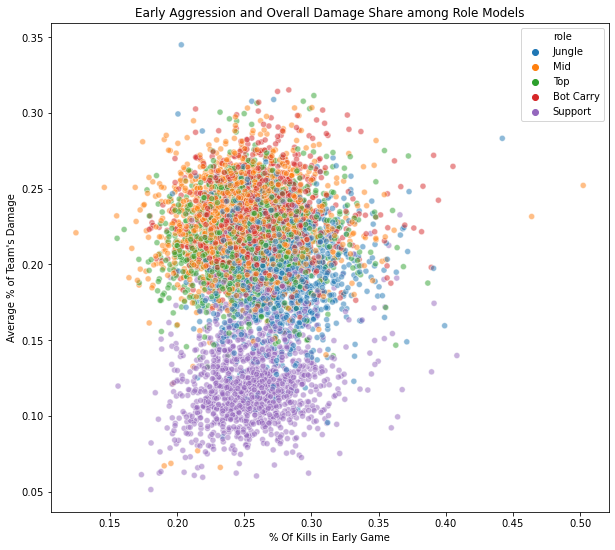

In [25]:
plt.figure(figsize=(10,9))
sns.scatterplot(data=player_df, x='kda_early', y='dmg_share', alpha=.5, hue='role')
plt.xlabel('% Of Kills in Early Game')
plt.ylabel("Average % of Team's Damage")
plt.title('Early Aggression and Overall Damage Share among Role Models');

## Recommender

Now that we have our Role Models data, we just need to build out the logic which outputs recommendations.

As a demo, we have sourced the most recent matches and timelines for a test subject, JR, and run their games through the same `get_data` function that processed our Role Models. 

Our recommender will simply scale the target columns and identify the closest matches using Euclidean Distance.

In [26]:
role_models = pd.read_csv('../data/role_models_3.csv')
jr = pd.read_csv('../data/jr_test.csv')

In [35]:
X = role_models[features[:-1]]
y = jr[features[:-1]]

In [36]:
ss = StandardScaler()
X_sc = ss.fit_transform(X)
y_sc = ss.transform(y)

X_sc = pd.DataFrame(X_sc, columns = X.columns)
y_sc = pd.DataFrame(y_sc, columns = X.columns)


In [37]:
diff_df = X_sc - y_sc.iloc[0,:]
norms = diff_df.apply(np.linalg.norm, ord=2, axis=1)

In [38]:
role_models['jr_similarity'] = norms

We will display the 10 best and worst matches against our test user:

In [45]:
pd.set_option('display.max_columns', 50)
result = pd.concat([pd.concat([jr,role_models.sort_values('jr_similarity')]).head(10),role_models.sort_values('jr_similarity').tail(10)])
result

csd_10   gold_d_10      xpd_10  dmg_share  dmg_taken_share  \
0     1.055435  204.533696  267.578261   0.130517         0.157633   
2815  2.977778  219.190476  301.158730   0.139154         0.135513   
2464  2.003150  217.700787  290.233071   0.142265         0.146133   
6714  2.106250  227.421875  308.200000   0.144354         0.131747   
5964  1.514634  205.170732  289.584390   0.128415         0.142984   
5811  1.570000  213.243333  299.580000   0.152667         0.140807   
6299  2.673973  222.328767  320.221918   0.145952         0.135589   
3177  2.375758  206.421212  284.806061   0.144075         0.122063   
6485  1.244898  200.820408  278.114286   0.101213         0.173766   
2334  1.425806  190.609677  266.200000   0.119624         0.134935   
6940  1.452941  295.694118  335.173529   0.159458         0.256067   
1463  1.006593  330.385714  378.840659   0.233622         0.280797   
1430  0.879167  343.608333  397.247917   0.235447         0.280682   
1548  0.737500  334.691250  352.800000   0.199024         0.229048   
5161  1.537838  195.697297  271.193243   0.104000         0.134357   
6934  6.817647  312.308824  335.585294   0.264611         0.184772   
957   1.434375  350.706250  429.975000   0.198157         0.284298   
6804  4.736842  341.830526  413.812632   0.283116         0.224012   
6922  5.334286  287.857143  421.745714   0.231527         0.221611   
6780  5.523077  306.166346  445.237500   0.252047         0.231000   

      vision_score  kill_participation  obj_dmg_share   dragons    barons  \
0        48.184783            0.496008       0.067509  0.396752  0.172101   
2815     42.650794            0.510629       0.065101  0.386092  0.166667   
2464     51.527559            0.525452       0.063397  0.368685  0.188320   
6714     52.437500            0.497170       0.074393  0.433966  0.231771   
5964     52.682927            0.535951       0.077863  0.400174  0.193496   
5811     52.677778            0.537627       0.062133  0.393995  0.202778   
6299     40.479452            0.512462       0.089303  0.426745  0.171233   
3177     43.393939            0.534487       0.093518  0.398617  0.217677   
6485     48.530612            0.486870       0.116528  0.370505  0.214286   
2334     60.741935            0.527022       0.057274  0.428495  0.190860   
6940     32.352941            0.453124       0.423870  0.396218  0.210784   
1463     19.769231            0.536880       0.484021  0.450693  0.249084   
1430     20.281250            0.546307       0.529005  0.477455  0.204861   
1548     19.612500            0.570662       0.349995  0.350342  0.164583   
5161     60.297297            0.526385       0.051365  0.384106  0.206081   
6934     20.029412            0.498987       0.193246  0.357318  0.188235   
957      17.468750            0.466359       0.467694  0.384226  0.197917   
6804     21.989474            0.544235       0.357669  0.445246  0.265789   
6922     18.514286            0.444366       0.198515  0.262313  0.130952   
6780     18.923077            0.446250       0.223887  0.446646  0.176282   

      wards_cleared  vision_wards_purchased  kda_early   kda_mid  kda_late  \
0          0.197834                0.175810   0.182421  0.405672  0.359986   
2815       0.263137                0.209774   0.202459  0.420101  0.311830   
2464       0.222185                0.149101   0.219274  0.397183  0.313857   
6714       0.320732                0.180327   0.199581  0.397100  0.344809   
5964       0.160617                0.171807   0.219980  0.412132  0.307969   
5811       0.198772                0.220034   0.216553  0.388537  0.337962   
6299       0.172553                0.108293   0.196162  0.422449  0.311992   
3177       0.233122                0.121854   0.188534  0.415191  0.332138   
6485       0.191419                0.138851   0.226922  0.404299  0.312317   
2334       0.193109                0.236990   0.156043  0.425920  0.354970   
6940       1.115959                1.979958   0.399092  0.367

## Evaluation and User Feedback
As previously mentioned, our model can't be objectively evaluated easily. However, here are a summary of pros and cons in its subjective performance:

**Pros:**
- The highest-similarity results are almost always players with the same main role, and will often include multiple players with the same main champion. Insofar as role and champion are useful heuristics for playstyle, this is promising.
- We can readily observe major differences in the stat lines between good and poor recommendations, especially and most importantly on stats which are not in reference to the team, such as laning stats and warding by game phase. 

**Cons:**
- The main issue we've seen in testing is that lower-ranked input players often tend to receive recommendations who are in the lower skill range of our Role Models. This reflects the aforementioned "apples to oranges" issues that come with comparing players across large rank gaps. This isn't necessarily a problem, as it's quite possible that a low-rank player can more readily compare their gameplay to extremely good players than the very best, and it was a concession we opted into in order to keep features which we felt had meaningful contributions to a player's "fingerprint."

Finally, here is a bit of user feedback from one of our testers:

"Personally, I found the champion stuff the most interesting part of the data, especially identifying trends across multiple players. I feel like the whole thing gave me some interesting ideas and allowed me to look at the way I play in a different way." 

This tester was what's known as a "One-Trick Pony" in League, which is to say that they almost exclusively play the same champion in every game. They've historically had trouble finding new champions to play which appeal to them given a finite amount of time to experiment outside of work, and so they were somewhat less interested in reviewing replays of similar players, and more interested in finding out what champions players like them enjoyed playing. 

Our methodology can easily be extended to recommending champions who have similar overall playstyles to a given player, and will be in the final Flask App. While users can certainly explore their Role Model recommendations' most-played champions, improving the user experience by suggesting champions which are a good fit would be a easily-implementable value add.

## Future Goals
- Deploy Flask App on Heroku (Main Hurdles: Managing API Rate Limits across asynchronous users, adding styling)
- Add Champion Recommendation component: what champions are most similar to your playstyle?
- Visualize similarity for the user to enhance sense of personalization and give feedback on playstyle


## References
- [Riot Games API](https://developer.riotgames.com/apis)
- [How Well does Personalized Marketing Work?](https://knowledge.wharton.upenn.edu/article/recommended-for-you-how-well-does-personalized-marketing-work/)
- [Recommender Systems in Python 101](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101)
- [Building the Next New York Times Recommendation Engine](https://open.blogs.nytimes.com/2015/08/11/building-the-next-new-york-times-recommendation-engine)
- [The Netflix Recommender System: Algorithms, Business Value, and Innovation](https://dl.acm.org/doi/10.1145/2843948)
- [How Machine Learning Fuels Your Netflix Addiction](https://www.rtinsights.com/netflix-recommendations-machine-learning-algorithms/)
- [The Treasure Chest of League of Legends: Riot’s APIs](https://medium.com/@montane/the-treasure-chest-of-league-of-legends-riots-apis-64816f4d3f84)
- [Part 1 of Riot API: Data Downpour](https://towardsdatascience.com/data-downpour-b1c4b41d7862)